Run on NERSC

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits
import healpy as hp
from astropy import wcs

import match_coord

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
def plot_cutout(img, pixscale, decraoff=None, vmin=-1, vmax=1, unit='arcsec', axis_label=None, colorbar=False, cbar_label=None, title=None, axis=None, figsize=(8, 8)):
    '''
    decraoff: [dec_offset, ra_offset]
    '''
    if unit=='arcsec':
        rescale = 1.
    elif unit=='arcmin':
        rescale = 60.
    elif unit=='deg':
        rescale = 3600.
    else:
        raise ValueError('unrecognized unit')
    extent = 0.5*pixscale*(img.shape[1]*np.array([-1, 1, 0, 0])+img.shape[0]*np.array([0, 0, -1, 1]))/rescale

    if decraoff is not None:
        dec_offset, ra_offset = decraoff
        extent[0] -= dec_offset # DEC
        extent[1] -= dec_offset # DEC
        extent[2] += ra_offset # RA
        extent[3] += ra_offset # RA
    
    fig, ax = plt.subplots(figsize=figsize)
    dens = ax.imshow(img, aspect='equal',
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    ax.axvline(0, ls='--', lw=0.5, color='grey')
    ax.axhline(0, ls='--', lw=0.5, color='grey')
    if colorbar:
        cbar = fig.colorbar(dens, fraction=0.046, pad=0.04)
    if cbar_label is not None:
        cbar.ax.set_ylabel(cbar_label)
    ax.grid(alpha=0.5)
    if axis_label is not None:
        ax.set_xlabel(axis_label[0])
        ax.set_ylabel(axis_label[1])
    if title is not None:
        ax.set_title(title)
    if axis is not None:
        ax.axis(axis)
    return ax

def plot_cutout_sidebyside(img1, img2, pixscale, decraoff=None, vmin=-1, vmax=1, unit='arcsec', axis_label=None, axis=None, title1=None, title2=None, figsize=(20, 10), crosshair=True, grid=False):
    '''
    decraoff: [dec_offset, ra_offset]
    '''
    if unit=='arcsec':
        rescale = 1.
    elif unit=='arcmin':
        rescale = 60.
    elif unit=='deg':
        rescale = 3600.
    else:
        raise ValueError('unrecognized unit')
    extent = 0.5*pixscale*(img1.shape[1]*np.array([-1, 1, 0, 0])+img1.shape[0]*np.array([0, 0, -1, 1]))/rescale

    if decraoff is not None:
        dec_offset, ra_offset = decraoff
        extent[0] -= dec_offset # DEC
        extent[1] -= dec_offset # DEC
        extent[2] += ra_offset # RA
        extent[3] += ra_offset # RA
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes[0].imshow(img1, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    if crosshair:
        axes[0].axvline(0, ls='--', lw=0.5, color='grey')
        axes[0].axhline(0, ls='--', lw=0.5, color='grey')
    if title1 is not None:
        axes[0].set_title(title1)
    im = axes[1].imshow(img2, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    axes[1].axvline(0, ls='--', lw=0.5, color='grey')
    axes[1].axhline(0, ls='--', lw=0.5, color='grey')
    if title2 is not None:
        axes[1].set_title(title2)
    if axis_label is not None:
        axes[0].set_xlabel(axis_label[0])
        axes[0].set_ylabel(axis_label[1])
        axes[1].set_xlabel(axis_label[0])
        axes[1].set_ylabel(axis_label[1])
    # fig.colorbar(im, fraction=0.046, pad=0.04)
    if grid:
        axes[0].grid(alpha=0.5)
        axes[1].grid(alpha=0.5)
    if axis is not None:
        axes[0].axis(axis)
        axes[1].axis(axis)
    return axes

In [4]:
from scipy.optimize import curve_fit

def get_frac_moffat(r, alpha, beta):
    """
    Calculate the fraction of light within radius r of a Moffat profile.
    """    
    frac = 1 - alpha**(2*(beta-1))*(alpha**2 + r**2)**(1-beta)
    return(frac)

def get_sb_moffat(r, alpha, beta):
    """
    Calculate the surface brightness of light at radius r of a Moffat profile.
    The integral (i.e., total flux) is unity by definition.
    """
    i = (beta-1)/(np.pi * alpha**2)*(1 + (r/alpha)**2)**(-beta)
    return i

def get_sb_moffat_plus_power_law(r, alpha1, beta1, plexp2, weight2):
    """
    Calculate the surface brightness of light at radius r of the sum of two Moffat profiles.
    The integral (i.e., total flux) is NOT unity.
    """
    i = (beta1-1)/(np.pi * alpha1**2)*(1 + (r/alpha1)**2)**(-beta1) \
        + weight2 *r**(plexp2)
    return i

def get_sb_double_moffat(r, alpha1, beta1, alpha2, beta2, weight2):
    """
    Calculate the surface brightness of light at radius r of the sum of two Moffat profiles.
    The integral (i.e., total flux) is NOT unity.
    """
    i = (beta1-1)/(np.pi * alpha1**2)*(1 + (r/alpha1)**2)**(-beta1) \
        + weight2 * (beta2-1)/(np.pi * alpha2**2)*(1 + (r/alpha2)**2)**(-beta2)
    return i

In [5]:
params = {
'g_weight2': 0.00045, 'g_plexp2': -2.,
'r_weight2': 0.00033, 'r_plexp2': -2.,
'z_alpha2': 17.650, 'z_beta2': 1.7, 'z_weight2': 0.0145,
}

outlier_ccd_list = ['N20', 'S8', 'S10', 'S18', 'S21', 'S27']
params_outlier = {'z_alpha2': 16, 'z_beta2': 2.3, 'z_weight2': 0.0095}

field = 'south'
region_name = 'decals_ngc'
pixscale = 0.262

In [6]:
ccd_columns = ['image_filename', 'image_hdu', 'camera', 'expnum', 'ccdname', 'filter', 'fwhm', 'ra', 'dec', 'ccd_cuts', 'ccdzpt', 'exptime', 'ccdraoff', 'ccddecoff']
surveyccd_path = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/survey-ccds-decam-dr9-cut.fits.gz'

ccd = fitsio.read(surveyccd_path, columns=ccd_columns)
ccd = Table(ccd)

mask = ccd['ccd_cuts']==0
print(np.sum(mask)/len(mask))
ccd = ccd[mask]

# plt.figure(figsize=(10, 5))
# plt.plot(ccd['ra'][::10], ccd['dec'][::10], '.', ms=0.1)
# plt.show()

gaia = Table.read('/global/homes/r/rongpu/notebooks/bright_star_profiles/data/gaia_sample_for_ccd_cutouts-decals_ngc.fits')

0.560352050046


__Choose filter, GAIA star, CCD, etc.__

In [94]:
band = 'g'
vrange = 0.1
gaia_index = 1
ccd1_index = 0

__Find the CCDs that cover the GAIA stars__

In [95]:
# maximum RA, Dec separation for DECam CCDs
max_d_ra, max_d_dec = 4096*0.262/2, 2046*0.262/2
max_d_ra, max_d_dec = max_d_ra*0.95, max_d_dec*0.95 # trim CCD edges

idx1, idx2, d2d, d_ra, d_dec = match_coord.search_around(gaia['ra'], gaia['dec'], ccd['ra'], ccd['dec'], search_radius=max(max_d_ra, max_d_dec))

mask = np.abs(d_ra)<max_d_ra
mask &= np.abs(d_dec)<max_d_dec
print(np.sum(mask))
mask &= ccd['filter'][idx2]==band
print(np.sum(mask))
idx1 = idx1[mask]
idx2 = idx2[mask]

3173 nearby objects
1913
655


## Moffat fit of the PSFEx model

186.169575077 1.38401239831
1   phot_g_mean_mag=6.850   ls_g=8.254
3 CCD images available
alpha, beta = 0.762, 2.491


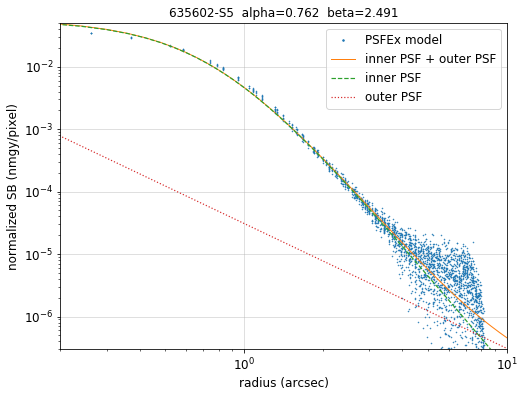

In [96]:
gaia_mask = idx1==gaia_index
if np.sum(gaia_mask)==0:
    raise ValueError

ra, dec = gaia['ra'][gaia_index], gaia['dec'][gaia_index]
print(ra, dec)
print('{}   phot_g_mean_mag={:.3f}   ls_{}={:.3f}'.format(gaia_index, gaia['phot_g_mean_mag'][gaia_index], band, gaia['ls_'+band][gaia_index]))

ccd1 = ccd[idx2[gaia_mask]]
print(len(ccd1), 'CCD images available')

expnum_str = str(ccd1['expnum'][ccd1_index])
ccdname = ccd1['ccdname'][ccd1_index]
fn_prefix = ccd1['camera'][ccd1_index]+'-'+(5-len(expnum_str[:3]))*'0'+expnum_str+'-'+ccdname
# print(fn_prefix)
# print('seeing = {:.2f} arcsec'.format(ccd1['seeing'][ccd1_index]))
# print('airmass = {:.2f}'.format(ccd1['airmass'][ccd1_index]))

########## Outer PSF parameters ###########
if band=='z' and (ccdname in outlier_ccd_list):
    params_to_use = params_outlier
else:
    params_to_use = params
    
if band!='z':
    plexp2, weight2 = params_to_use[band+'_plexp2'], params_to_use[band+'_weight2']
else:
    alpha2, beta2, weight2 = params_to_use[band+'_alpha2'], params_to_use[band+'_beta2'],  params_to_use[band+'_weight2']

################# PSFEx #################
image_filename = ccd1['image_filename'][ccd1_index]
psfex_filename = image_filename[:image_filename.find('.fits.fz')]+'-psfex.fits'
psfex_fn = os.path.join('/project/projectdirs/cosmo/work/legacysurvey/dr9/calib', psfex_filename)

hdu = fits.open(psfex_fn)
data = hdu[1].data
psfex_index = np.where(data['ccdname']==ccdname)[0][0]

psf0 = data['psf_mask'][psfex_index, 0]
# normalize to a 22.5 magnitude star
psf0 = psf0/np.sum(psf0)

# vrange = 0.0002
# ax = plot_cutout(psf0, pixscale, vmin=-vrange, vmax=vrange, axis_label=['DEC direction (arcsec)', 'RA direction (arcsec)'])
# plt.show()

grid = pixscale * np.linspace(-0.5*(psf0.shape[0]-1), 0.5*(psf0.shape[0]-1), psf0.shape[0])
xx, yy = np.meshgrid(grid, grid)
radius_grid = np.sqrt(xx**2 + yy**2)
radius = radius_grid.flatten()

################# Moffat fit ##############

radius_min, radius_max = 1.8, 5.0

psf0_flat = psf0.flatten()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # popt, pcov =  curve_fit(get_sb_moffat, radius, psf0_flat/(pixscale**2))
    mask = (radius>radius_min) & (radius<radius_max)
    popt, pcov = curve_fit(get_sb_moffat, radius[mask], psf0_flat[mask]/(pixscale**2), bounds=((0, 1.8), np.inf))

alpha, beta = popt
print('alpha, beta = {:.3f}, {:.3f}'.format(alpha, beta))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    radius_plot = np.linspace(0, 30, 500)
    if band!='z':
        psf_predict = pixscale**2 * get_sb_moffat_plus_power_law(radius_grid, alpha, beta, plexp2, weight2)
        psf_plot = pixscale**2 * get_sb_moffat_plus_power_law(radius_plot, alpha, beta, plexp2, weight2)
        psf_plot1 = pixscale**2 * get_sb_moffat(radius_plot, alpha, beta)
        psf_plot2 = weight2 * pixscale**2 * radius_plot**(plexp2)
    else:
        psf_predict = pixscale**2 * get_sb_double_moffat(radius_grid, alpha, beta, alpha2, beta2, weight2)
        psf_plot = pixscale**2 * get_sb_double_moffat(radius_plot, alpha, beta, alpha2, beta2, weight2)
        psf_plot1 = pixscale**2 * get_sb_moffat(radius_plot, alpha, beta)
        psf_plot2 = weight2 * pixscale**2 * get_sb_moffat(radius_plot, alpha2, beta2)

    plt.figure(figsize=(8, 6))
    plt.loglog(radius, psf0_flat, '.', ms=1., label='PSFEx model')
    plt.loglog(radius_plot, psf_plot, '-', lw=1, label='inner PSF + outer PSF')
    plt.loglog(radius_plot, psf_plot1, '--', lw=1.2, alpha=1., label='inner PSF')
    plt.loglog(radius_plot, psf_plot2, ':', lw=1.2, alpha=1., label='outer PSF')
    mask = radius_plot>0.5
    # plt.loglog(radius_plot[mask], 10**(profile_fit(np.log10(radius_plot)))[mask], 'C2--', lw=1.2, label='polynomial')
    plt.axis([0.2, 10, 3e-7, 0.05])
    plt.grid(alpha=0.5)
    plt.xlabel('radius (arcsec)')
    plt.ylabel('normalized SB (nmgy/pixel)')
    plt.title('{}-{}  alpha={:.3f}  beta={:.3f}'.format(expnum_str, ccdname, alpha, beta))
    plt.legend(markerscale=3)
    plt.show()

__Modify the PSFEx image__

In [97]:
radius_lim1, radius_lim2 = 5.0, 6.0
radius_lim3, radius_lim4 = 7., 8.

psf0_hybrid = psf0.copy()

r1, r2 = radius_lim1, radius_lim2
mask = (radius_grid>r1) & (radius_grid<r2)
psf0_hybrid[mask] = psf0[mask] * (r2-radius_grid[mask])/(r2-r1) \
               + psf_predict[mask] * (radius_grid[mask]-r1)/(r2-r1)

r1, r2 = radius_lim2, radius_lim3
mask = (radius_grid>=r1) & (radius_grid<r2)
psf0_hybrid[mask] = psf_predict[mask]

r1, r2 = radius_lim3, radius_lim4
mask = (radius_grid>=r1) & (radius_grid<r2)
psf0_hybrid[mask] = psf_predict[mask] * (r2-radius_grid[mask])/(r2-r1) \
               + 0 * (radius_grid[mask]-r1)/(r2-r1)

mask = (radius_grid>radius_lim4)
psf0_hybrid[mask] = 0

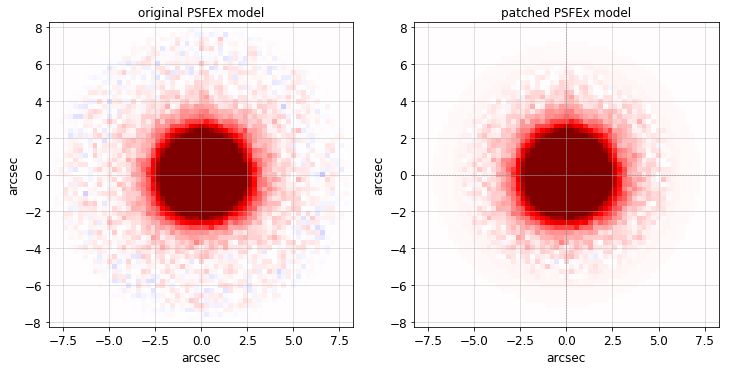

In [98]:
psf_vrange = 0.00015

# plot_cutout(psf0, pixscale, vmin=-psf_vrange, vmax=psf_vrange, figsize=(6, 6), title='original PSFEx model', axis_label=['arcsec', 'arcsec'])
# plt.show()
# plot_cutout(psf0_hybrid, pixscale, vmin=-psf_vrange, vmax=psf_vrange, figsize=(6, 6), title='patched PSFEx model', axis_label=['arcsec', 'arcsec'])
# plt.show()

plot_cutout_sidebyside(psf0, psf0_hybrid, pixscale, vmin=-psf_vrange, vmax=psf_vrange, figsize=(12, 6), title1='original PSFEx model', title2='patched PSFEx model', crosshair=False, grid=True, axis_label=['arcsec', 'arcsec'])
plt.show()

## Subtract the extended PSF of a bright star from a CCD image

__Load image__

In [99]:
image_dir = '/global/project/projectdirs/cosmo/staging/'
fn = os.path.join(image_dir, ccd1['image_filename'][ccd1_index])
# print(fn)

hdulist = fits.open(fn)
# print(hdu[ccd1['image_hdu'][ccd1_index]].header)
img_raw = hdulist[ccd1['image_hdu'][ccd1_index]].data

# naive sky subtraction
mask = (img_raw<np.percentile(img_raw.flatten(), 85))
img = img_raw - np.median(img_raw[mask].flatten())
# convert to nanomaggie per pixel
img = img / 10**((ccd1['ccdzpt'][ccd1_index]-22.5)/2.5) / ccd1['exptime'][ccd1_index]

xgrid = pixscale * np.linspace(-0.5*(img.shape[1]-1), 0.5*(img.shape[1]-1), img.shape[1])
ygrid = pixscale * np.linspace(-0.5*(img.shape[0]-1), 0.5*(img.shape[0]-1), img.shape[0])
xx, yy = np.meshgrid(xgrid, ygrid)

# astrometric correction
ccdraoff, ccddecoff = -ccd1['ccdraoff'][ccd1_index], -ccd1['ccddecoff'][ccd1_index]

w = wcs.WCS(hdulist[ccd1['image_hdu'][ccd1_index]].header)
xpixcenter, ypixcenter = w.wcs_world2pix([[ra, dec]], True)[0]
if (xpixcenter<0) or (ypixcenter<0) or (xpixcenter>img.shape[1]) or (ypixcenter>img.shape[0]):
    raise ValueError ('outside the CCD!!!')
    # print('outside the CCD!!!')
    # continue

print('Exposure: {}  CCD: {}'.format(expnum_str, ccdname))

ccddecoff += pixscale*(xpixcenter-(img.shape[1]/2+0.5))
ccdraoff += pixscale*(ypixcenter-(img.shape[0]/2+0.5))

xx, yy = xx - ccddecoff, yy - ccdraoff

radius_grid = np.sqrt(xx**2 + yy**2)
radius = radius_grid.flatten()
radius_plot = np.logspace(-1, 3, 1000)
flux = img.flatten()

Exposure: 635602  CCD: S5


__Compute the combined inner+outer PSF__

In [100]:
# normalization of a 22.5 magnitude star
norm_factor =  10**((gaia['ls_'+band][gaia_index]-22.5)/2.5)

if band!='z':
    img_predict = pixscale**2 * get_sb_moffat_plus_power_law(radius_grid, alpha, beta, plexp2, weight2) / norm_factor
    flux_plot = pixscale**2 * get_sb_moffat_plus_power_law(radius_plot, alpha, beta, plexp2, weight2)
    flux_plot1 = pixscale**2 * get_sb_moffat(radius_plot, alpha, beta)
    flux_plot2 = weight2 * pixscale**2 * radius_plot**(plexp2)
else:
    img_predict = pixscale**2 * get_sb_double_moffat(radius_grid, alpha, beta, alpha2, beta2, weight2) / norm_factor
    flux_plot = pixscale**2 * get_sb_double_moffat(radius_plot, alpha, beta, alpha2, beta2, weight2)
    flux_plot1 = pixscale**2 * get_sb_moffat(radius_plot, alpha, beta)
    flux_plot2 = weight2 * pixscale**2 * get_sb_moffat(radius_plot, alpha2, beta2)

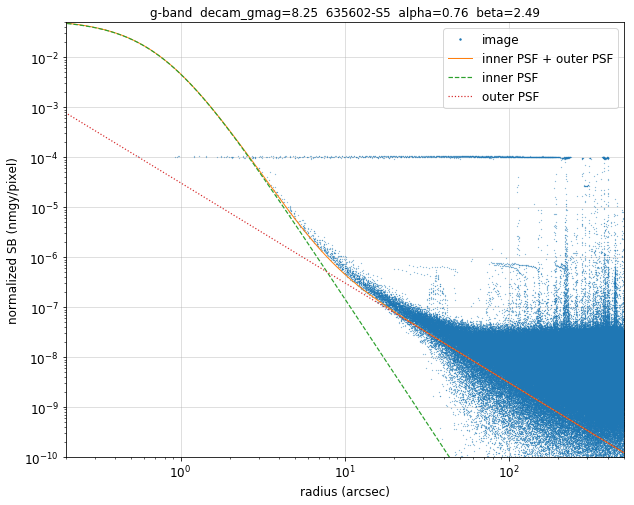

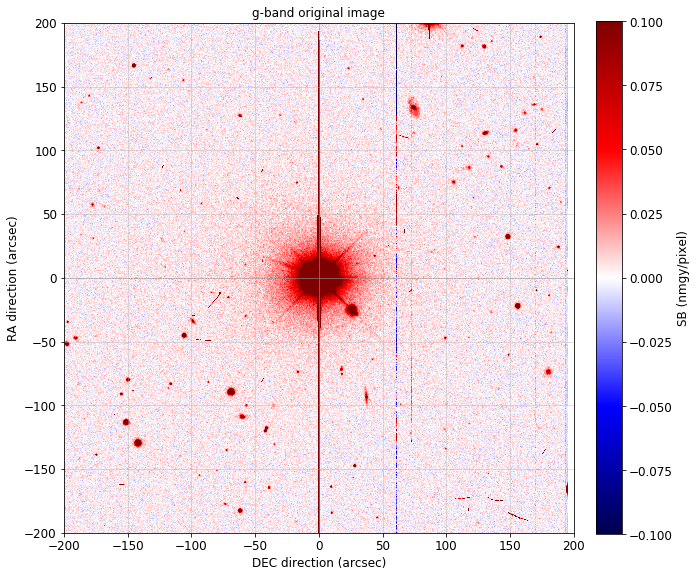

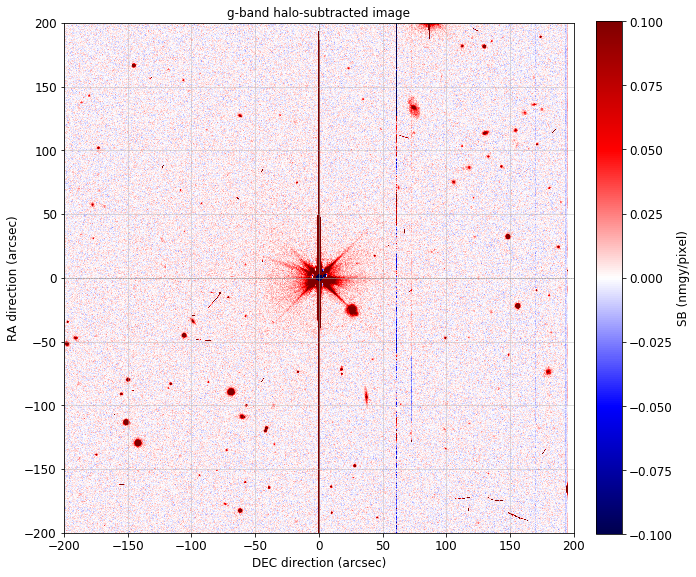

In [101]:
# plt.figure(figsize=(20, 10))
# plt.imshow(img.T, cmap='seismic', vmin=-vrange, vmax=vrange)
# plt.show()

# plt.figure(figsize=(20, 10))
# plt.imshow((img-img_predict).T, cmap='seismic', vmin=-vrange, vmax=vrange)
# plt.show()

mask = radius<500
plt.figure(figsize=(10, 8))
plt.loglog((radius[mask])[::10], norm_factor*(flux[mask])[::10], '.', ms=0.4, label='image')
plt.loglog(radius_plot, flux_plot, '-', lw=1, label='inner PSF + outer PSF')
plt.loglog(radius_plot, flux_plot1, '--', lw=1.2, alpha=1., label='inner PSF')
plt.loglog(radius_plot, flux_plot2, ':', lw=1.2, alpha=1., label='outer PSF')
mask = radius_plot>0.5
# plt.loglog(radius_plot[mask], 10**(profile_fit(np.log10(radius_plot[mask]))), 'y--', lw=1.2, label='polynomial')
plt.axis([0.2, 500, 1e-10, 0.05])
plt.grid(alpha=0.5)
plt.title('{}-band  decam_{}mag={:.2f}  {}-{}  alpha={:.2f}  beta={:.2f}'.format(band, band, gaia['ls_'+band][gaia_index], expnum_str, ccdname, alpha, beta))
plt.xlabel('radius (arcsec)')
plt.ylabel('normalized SB (nmgy/pixel)')
plt.legend(markerscale=7)
plt.show()

# ax = plot_cutout_sidebyside(img, img-img_predict, pixscale, decraoff=[ccddecoff, ccdraoff], vmin=-vrange, vmax=vrange,      axis_label=['DEC direction (arcsec)', 'RA direction (arcsec)'], axis=[-200, 200, -200, 200], title1='image', title2='residual')
# plt.show()

plot_cutout(img, pixscale, decraoff=[ccddecoff, ccdraoff], vmin=-vrange, vmax=vrange, axis_label=['DEC direction (arcsec)', 'RA direction (arcsec)'], axis=[-200, 200, -200, 200], title='{}-band original image'.format(band), figsize=(10, 10), colorbar=True, cbar_label='SB (nmgy/pixel)')
plt.show()

plot_cutout(img-img_predict, pixscale, decraoff=[ccddecoff, ccdraoff], vmin=-vrange, vmax=vrange, axis_label=['DEC direction (arcsec)', 'RA direction (arcsec)'], axis=[-200, 200, -200, 200], title='{}-band halo-subtracted image'.format(band), figsize=(10, 10), colorbar=True, cbar_label='SB (nmgy/pixel)')
plt.show()